# Section 3.2: Direction- and intensity-dependent neural entrainment to tACS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pickle
import simnibs
import os, subprocess
import scipy
import plot_functions
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import scipy.stats as stats

# Figure 3(a): PLV sensitivity to E-field direction (unifrom E-field, 1V/m, 10Hz)

In [2]:
# Load data: neural entrainment across the full range of possible field directions
dataPath = 'data_paper/L5PC_Clone4_PLV_sensitivity_to_Efield_410_directions_1mVmm_10Hz.p'
data_410_direction = pickle.load(open(dataPath, 'rb'))
plv_410_direction  = np.array([item[0] for item in data_410_direction])
print('PLV min = %.4f, PLV max = %.4f' % (plv_410_direction.min(), plv_410_direction.max()))

# Transfer list data to matrix data
list_theta = np.arange(0, 181, 10)
list_phi   = np.arange(0, 361, 15)
list_theta = np.deg2rad(list_theta - 90)
list_phi   = np.deg2rad(list_phi - 180)
matrix_plv = np.zeros((len(list_theta), len(list_phi)))
matrix_plv[0, :] += plv_410_direction[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_plv[i, j] = plv_410_direction[num]
        num += 1
    matrix_plv[i, -1] = plv_410_direction[num - len(list_phi) + 1]
matrix_plv[-1, :] += plv_410_direction[-1]
matrix_plv = np.hstack((matrix_plv[:,12:-1], matrix_plv[:,0:13]))

# Interpolate matrix plv to smooth data points
interp_func       = scipy.interpolate.interp2d(list_phi, list_theta, matrix_plv, kind='linear')
inter_phi         = np.linspace(list_phi[0], list_phi[-1], 361*2)
interp_theta      = np.linspace(list_theta[0], list_theta[-1], 181*2)
matrix_plv_interp = interp_func(inter_phi, interp_theta)

# Get the coordinates of contours
contour = plt.contour(inter_phi, interp_theta, np.flip(matrix_plv_interp, axis=0), levels=[0.015, 0.025, 0.035])
plt.close()
contour_coords_interp = []
for i, collection in enumerate(contour.collections):
    for path in collection.get_paths():
        coords = path.vertices  # coordinate of each contour
        contour_coords_interp.append(coords)

# colorbar ranges
maximum_plv     = np.round(max(matrix_plv.max(), matrix_plv_interp.max()), decimals=3)
minimum_plv     = np.round(min(matrix_plv.min(), matrix_plv_interp.min()), decimals=3)
cbar_ticks      = np.array([0.015, 0.025, 0.035, maximum_plv])
cbar_ticks_norm = (cbar_ticks - minimum_plv) / (maximum_plv - minimum_plv)

# Selected five points randomly
list_points         = [[0, 0], [60, 75], [100, 210], [150, 300], [180, 0]]
list_points_markers = ['*', 'd', 'o', 's', '^']
list_points_sizes   = np.array([70, 50, 50, 45, 55]) - 30

PLV min = 0.0088, PLV max = 0.0370


C:\Users\Snowp\AppData\Local\Temp\ipykernel_33416\4138426788.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour.collections):


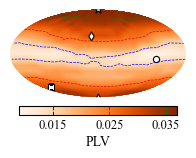

In [3]:
# plot plv-direction sensitivity
fig  = plt.figure(figsize=(5, 3))
ax   = fig.add_subplot(1, 2, 1, projection="mollweide")
norm = matplotlib.colors.Normalize(vmin=minimum_plv, vmax=maximum_plv)
ax.pcolormesh(inter_phi, interp_theta, np.flip(matrix_plv_interp, axis=0), shading='auto', cmap='Oranges', norm=norm)
# plot contours
linewidth = 0.5
contour_colors = ['b', 'r', 'g']
for j, item in enumerate(contour_coords_interp):
    if j == 0:
        ax.plot(item[:,0][:810], item[:,1][:810], lw=linewidth, ls='--', color=contour_colors[j])
        ax.plot(item[:,0][825:], item[:,1][825:], lw=linewidth, ls='--', color=contour_colors[j])
    elif j == 1:
        ax.plot(item[:,0][:790], item[:,1][:790], lw=linewidth, ls='--', color=contour_colors[j])
        ax.plot(item[:,0][800:], item[:,1][800:], lw=linewidth, ls='--', color=contour_colors[j])
    else:
        ax.plot(item[:,0], item[:,1], lw=linewidth, ls='--', color=contour_colors[j])
# ax.axhline(np.deg2rad(30), ls='--', lw=1, color='gray')
# ax.axhline(np.deg2rad(-30), ls='--', lw=1, color='gray')

# five point markers
for i in range(len(list_points)):
    theta = - np.deg2rad(list_points[i][0] - 90)
    phi   = list_points[i][1] - 90
    if phi < 180:
        phi += 360
    if phi > 180:
        phi -= 360
    phi   = np.deg2rad(phi)
    ax.scatter(phi, theta, marker=list_points_markers[i], s=list_points_sizes[i], facecolor='white', edgecolor='k', lw=0.8)

ax.axis('off')
# plot colorbar
cmap = plt.get_cmap('Oranges', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0.05, -0.2, 0.9, 0.1]), location='bottom', orientation='horizontal')
cbar.set_ticks(cbar_ticks_norm)
cbar.set_ticklabels(['0.015', '0.025', '0.035', ''], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3, length=0.1)
cbar.ax.axvline(cbar_ticks_norm[0], color='b', lw=0.7, ls='--')
cbar.ax.axvline(cbar_ticks_norm[1], color='r', lw=0.7, ls='--')
cbar.ax.axvline(cbar_ticks_norm[2], color='g', lw=0.7, ls='--')
cbar.set_label('PLV', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3a-1.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

(-3.141592653589793,
 3.141592653589793,
 -1.5707963267948966,
 1.5707963267948966)

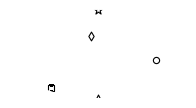

In [4]:
fig  = plt.figure(figsize=(5, 3))
ax   = fig.add_subplot(1, 2, 1, projection="mollweide")
# five point markers
for i in range(len(list_points)):
    theta = - np.deg2rad(list_points[i][0] - 90)
    phi   = list_points[i][1] - 90
    if phi < 180:
        phi += 360
    if phi > 180:
        phi -= 360
    phi   = np.deg2rad(phi)
    ax.scatter(phi, theta, marker=list_points_markers[i], s=list_points_sizes[i], facecolor='white', edgecolor='k', lw=0.8)
ax.axis('off')

# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3a-2.svg',format='svg',transparent=True,dpi=600,bbox_inches='tight')
# plot_functions.svg_to_emf(r'C:\Users\Snowp\Desktop\paperFigures\figure3a-2.svg')

# Figure 3(b): PPh sensitivity to E-field direction

In [4]:
# Load data: neural entrainment across the full range of possible field directions
dataPath = 'data_paper/L5PC_Clone4_PLV_sensitivity_to_Efield_410_directions_1mVmm_10Hz.p'
data_410_direction = pickle.load(open(dataPath, 'rb'))
pph_410_direction  = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data_410_direction])
# Transfer list data to matrix data
list_theta = np.arange(0, 181, 10)
list_phi   = np.arange(0, 361, 15)
list_theta = np.deg2rad(list_theta - 90)
list_phi   = np.deg2rad(list_phi - 180)
matrix_pph = np.zeros((len(list_theta), len(list_phi)))
matrix_pph[0, :] += pph_410_direction[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_pph[i, j] = pph_410_direction[num]
        num += 1
    matrix_pph[i, -1] = pph_410_direction[num - len(list_phi) + 1]
matrix_pph[-1, :] += pph_410_direction[-1]
matrix_pph = np.hstack((matrix_pph[:,12:-1], matrix_pph[:,0:13]))

# Interpolate matrix pph to smooth data points
interp_func       = scipy.interpolate.interp2d(list_phi, list_theta, matrix_pph, kind='linear')
inter_phi         = np.linspace(list_phi[0], list_phi[-1], 361*2)
interp_theta      = np.linspace(list_theta[0], list_theta[-1], 181*2)
matrix_pph_interp = interp_func(inter_phi, interp_theta)

# colorbar ranges
maximum_pph     = 300
minimum_pph     = 150
cbar_ticks      = np.array([150, 180, 225, 270, 300])
cbar_ticks_norm = (cbar_ticks - minimum_pph) / (maximum_pph - minimum_pph)
# Get the coordinates of contours
contour = plt.contour(inter_phi, interp_theta, np.flip(matrix_pph_interp, axis=0), levels=[180, 270])
plt.close()
contour_coords_interp = []
for i, collection in enumerate(contour.collections):
    for path in collection.get_paths():
        coords = path.vertices  # coordinate of each contour
        contour_coords_interp.append(coords)
# Selected five points randomly
list_points         = [[0, 0], [60, 75], [100, 210], [150, 300], [180, 0]]
list_points_markers = ['*', 'd', 'o', 's', '^']
list_points_sizes   = np.array([70, 50, 50, 45, 55]) - 30

C:\Users\Snowp\AppData\Local\Temp\ipykernel_33416\1681162320.py:36: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour.collections):


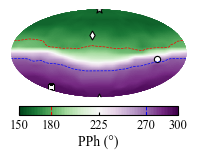

In [8]:
# plot plv-direction sensitivity
fig  = plt.figure(figsize=(5, 3))
ax   = fig.add_subplot(1, 2, 1, projection="mollweide")
norm = matplotlib.colors.Normalize(vmin=minimum_pph, vmax=maximum_pph)
ax.pcolormesh(inter_phi, interp_theta, np.flip(matrix_pph_interp, axis=0), shading='auto', cmap='PRGn_r', norm=norm)
# contour lines
linewidth = 0.5
contour_colors = ['r', 'b']
for j, item in enumerate(contour_coords_interp):
    ax.plot(item[:,0], item[:,1], lw=linewidth, ls='--', color=contour_colors[j])
# five point markers
for i in range(len(list_points)):
    theta = - np.deg2rad(list_points[i][0] - 90)
    phi   = list_points[i][1] - 90
    if phi < 180:
        phi += 360
    if phi > 180:
        phi -= 360
    phi   = np.deg2rad(phi)
    ax.scatter(phi, theta, marker=list_points_markers[i], s=list_points_sizes[i], facecolor='white', edgecolor='k', lw=0.8)

ax.axis('off')
# plot colorbar
cmap = plt.get_cmap('PRGn_r', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0.05, -0.2, 0.9, 0.1]), location='bottom', orientation='horizontal')
cbar.set_ticks(cbar_ticks_norm)
cbar.set_ticklabels(['150', '180', '225', '270', '300'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3, length=2)
cbar.ax.axvline(cbar_ticks_norm[1], color='r', lw=0.7, ls='--')
cbar.ax.axvline(cbar_ticks_norm[3], color='b', lw=0.7, ls='--')
cbar.set_label('PPh (°)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS3a.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 3(c): PLV sensitivity to E-field intensity

In [4]:
# Load data
data_paths = [
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta0_phi0.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta60_phi75.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta100_phi210.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta150_phi300.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta180_phi0.p']
list_plv = []
for i, path in enumerate(data_paths):
    data     = pickle.load(open(path, 'rb'))
    list_plv.append(np.array([item[0] for item in data]))
list_Eamp = np.arange(0., 2.1, 0.1)

list_points_markers = ['*', 'd', 'o', 's', '^']
list_points_sizes = np.array([70, 55, 52, 48, 52]) - 35
cmap           = plt.get_cmap('Greys', lut=25)
list_color     = [cmap(i) for i in range(21)]

R2 is 0.9881
R2 is 0.9518
R2 is 0.9353
R2 is 0.9724
R2 is 0.9826


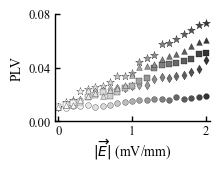

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2., 1.4))
for k in range(len(list_plv)):
    list_x, list_y = list_Eamp, list_plv[k]
    x, y = list_x, list_y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    xfit = np.linspace(-0.05, 2.05, 200)
    yfit = slope * xfit + intercept
    print('R2 is %.4f' % r_value**2)
    for i in range(len(list_x)):
        ax.scatter(list_x[i], list_y[i], marker=list_points_markers[k], s=list_points_sizes[k], lw=0.2, fc=list_color[i], ec='k')
        # ax.plot(xfit, yfit, lw=0.1, color='r')
        
ax.set_xlim(-0.05, 2.05)
ax.set_ylim(0, 0.08)
ax.set_yticks([0, 0.04, 0.08])
ax.set_xticks(np.arange(0, 2.1, 1))
ax.set_xlabel(r'$|\overrightarrow{E}|$ (mV/mm)', fontsize=10, labelpad=-1, fontdict={'family': 'times new roman'})
ax.set_ylabel('PLV', fontsize=10, labelpad=3, fontdict={'family': 'times new roman'})
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=9, width=1, labelfontfamily='times new roman')
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3b-1.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 3(d): PPh sensitivity to E-field intensity

In [6]:
# Load data
data_paths = [
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta0_phi0.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta60_phi75.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta100_phi210.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta150_phi300.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta180_phi0.p']
list_pph = []
for i, path in enumerate(data_paths):
    data     = pickle.load(open(path, 'rb'))
    list_pph.append(np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data]))
list_Eamp = np.arange(0., 2.1, 0.1)

list_points_markers = ['*', 'd', 'o', 's', '^']
list_points_sizes = np.array([70, 55, 52, 48, 52]) - 35
cmap           = plt.get_cmap('Greys', lut=25)
list_color     = [cmap(i) for i in range(21)]

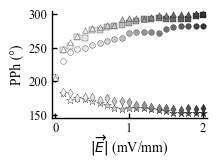

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2., 1.4))
for k in range(len(list_pph)):
    list_x, list_y = list_Eamp, list_pph[k]
    for i in range(len(list_x)):
        ax.scatter(list_x[i], list_y[i], marker=list_points_markers[k], s=list_points_sizes[k], \
               lw=0.2, fc=list_color[i], ec='k')
        
ax.set_xlim(-0.05, 2.05)
ax.set_ylim(145, 305)
# ax.set_yticks([0, 0.04, 0.08])
ax.set_xticks(np.arange(0, 2.1, 1))
ax.set_xlabel(r'$|\overrightarrow{E}|$ (mV/mm)', fontsize=10, labelpad=-1, fontdict={'family': 'times new roman'})
ax.set_ylabel('PPh (°)', fontsize=10, labelpad=3, fontdict={'family': 'times new roman'})
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=9, width=1, labelfontfamily='times new roman')
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS3b.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

R2 is 0.9345
R2 is 0.9001
R2 is 0.9721
R2 is 0.9738
R2 is 0.9839


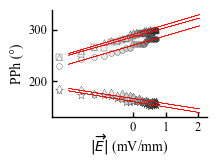

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(2., 1.4))
for k in range(len(list_pph)):
    list_x, list_y = np.log(list_Eamp[1:]), list_pph[k][1:]
    # list_x, list_y = np.log(list_Eamp[1:]), np.log(list_pph[k][1:])
    x, y = list_x, list_y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    xfit = np.linspace(-2, 2.05, 200)
    yfit = slope * xfit + intercept
    print('R2 is %.4f' % r_value**2)
    for i in range(len(list_x)):
        ax.scatter(list_x[i], list_y[i], marker=list_points_markers[k], s=list_points_sizes[k], \
               lw=0.2, fc=list_color[i], ec='k')
        ax.plot(xfit, yfit, lw=0.1, color='r')
# ax.set_xlim(-0.05, 2.05)
# ax.set_ylim(145, 305)
# ax.set_yticks([0, 0.04, 0.08])
ax.set_xticks(np.arange(0, 2.1, 1))
ax.set_xlabel(r'$|\overrightarrow{E}|$ (mV/mm)', fontsize=10, labelpad=-1, fontdict={'family': 'times new roman'})
ax.set_ylabel('PPh (°)', fontsize=10, labelpad=3, fontdict={'family': 'times new roman'})
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=3, direction='in', labelsize=9, width=1, labelfontfamily='times new roman')
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS3b.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S4: Polar histograms of tACS phase during spike onset with varying E-field intensities and directions

In [10]:
# Load data
data_paths = [
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta0_phi0.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta60_phi75.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta100_phi210.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta150_phi300.p',
    'data_paper/L5PC_Clone4_PLV_sensitivity_to_Eamp0-2mV_theta180_phi0.p']
list_indices = np.arange(0, 21, 5)
list_neural_entrainment_25data = []
for j, path in enumerate(data_paths):
    data     = pickle.load(open(path, 'rb'))
    list_neural_entrainment_25data.append([data[i] for i in list_indices])
list_Eamp    = np.arange(0., 2.1, 0.1)
cmap         = plt.get_cmap('Greys', lut=25)
list_color   = [cmap(i) for i in range(21)]

In [11]:
for i in range(len(data_paths)):
    for j in range(len(list_indices)):
        ax  = fig.add_subplot(len(data_paths), len(list_indices), i*len(list_indices)+j+1, projection='polar')
        current_neural_entrainment_data = list_neural_entrainment_25data[i][j]
        plv   = current_neural_entrainment_data[0]
        pph   = np.deg2rad((np.angle(current_neural_entrainment_data[2])*180/np.pi + 360) % 360)
        # rayleigh test
        _, _, p_value = plot_functions.rayleigh_test(np.deg2rad(current_neural_entrainment_data[1]))
        if p_value<=0.05 and p_value>0.01:
            print('(%d, %d): *' % (i+1, j+1))
        elif p_value<=0.01 and p_value>0.001:
            print('(%d, %d): **' % (i+1, j+1))
        elif p_value<=0.001:
            print('(%d, %d): ***' % (i+1, j+1))
        # print('(%d, %d)' % (i+1, j+1), f"p value of {i}-th direction: {p_value}")

(1, 4): *
(1, 5): ***
(4, 5): *
(5, 4): *
(5, 5): **


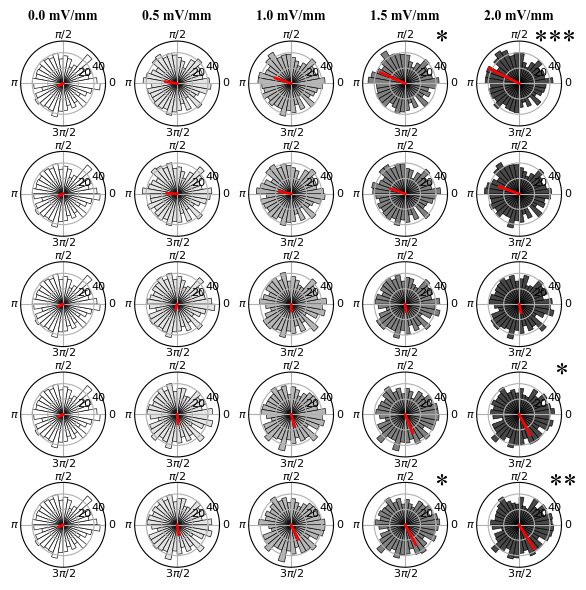

In [14]:
fig = plt.figure(figsize=(6, 6))
for i in range(len(data_paths)):
    for j in range(len(list_indices)):
        ax  = fig.add_subplot(len(data_paths), len(list_indices), i*len(list_indices)+j+1, projection='polar')
        current_neural_entrainment_data = list_neural_entrainment_25data[i][j]
        plv   = current_neural_entrainment_data[0]
        pph   = np.deg2rad((np.angle(current_neural_entrainment_data[2])*180/np.pi + 360) % 360)
        theta = np.radians(np.arange(5, 360, 10))
        bin_nums, bin_edges = np.histogram(current_neural_entrainment_data[1], bins=np.arange(0, 361, 10))
        width = np.radians(10)
        ax.bar(theta, bin_nums, width=width, bottom=0.0, facecolor=list_color[list_indices[j]], edgecolor='k', lw=0.5, alpha=0.9)
        ax.plot([pph, pph], [0, plv*600], color='r', linewidth=2)
        ax.set_ylim(0, 55)
        ax.set_yticks([20, 40])
        ax.set_xticks(np.deg2rad(np.array([0, 90, 180, 270])))
        ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'], fontsize=7)
        ax.tick_params(axis='both', labelsize=8, pad=-6)
        if i == 0:
            ax.set_title('%.1f mV/mm' % list_Eamp[list_indices[j]], fontsize=10, weight='bold', fontdict={'family': 'times new roman'})

color = 'k'
fig.text(0.74, 0.91, '*', fontdict={'family': 'times new roman', 'fontsize': 20}, color=color)
fig.text(0.905, 0.91, '***', fontdict={'family': 'times new roman', 'fontsize': 20}, color=color)
fig.text(0.94, 0.354, '*', fontdict={'family': 'times new roman', 'fontsize': 20}, color=color)
fig.text(0.74, 0.17, '*', fontdict={'family': 'times new roman', 'fontsize': 20}, color=color)
fig.text(0.93, 0.17, '**', fontdict={'family': 'times new roman', 'fontsize': 20}, color=color)

plt.tight_layout(w_pad=0., h_pad=0.)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS3d.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')